In [1]:
"""Backend supported: pytorch, paddle, jax

Implementation of the linear elasticity 2D example in paper https://doi.org/10.1016/j.cma.2021.113741.
References:
    https://github.com/sciann/sciann-applications/blob/master/SciANN-Elasticity/Elasticity-Forward.ipynb.
"""

import deepxde as dde
import numpy as np
import time
import os
import argparse
import jax
import jax.numpy as jnp


Using backend: jax
Other supported backends: tensorflow.compat.v1, tensorflow, pytorch, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



In [4]:



n_iter = 1000
log_every = 100
available_time = 0
log_output_fields = {0: 'Ux', 1: 'Uy', 2: 'Sxx', 3: 'Syy', 4: 'Sxy'}
net_type = 'spinn'
bc_type = 'hard'
mlp = 'mlp'
n_DIC = 6
noise_ratio = 0
lr = 0.001
u_0 = 1e-4
loss_weights = [1,1,1,1,1]


if net_type == "spinn":
    dde.config.set_default_autodiff("forward")

x_max = 1.0
y_max = 4.0
E = 210e3  # Young's modulus
nu = 0.3  # Poisson's ratio

lmbd = E * nu / ((1 + nu) * (1 - 2 * nu))  # Lame's first parameter
mu = E / (2 * (1 + nu))  # Lame's second parameter

# Load
pstress = 1.0


sin = dde.backend.sin
cos = dde.backend.cos
stack = dde.backend.stack


# Load geometry mapping
nx=25
ny=75
Xp = np.loadtxt(f"../geometry/deep_notched_{nx}x{ny}.txt")


# Interpolate mapping
X_map_points = Xp[:, 0].reshape((ny, nx)).T
Y_map_points = Xp[:, 1].reshape((ny, nx)).T

def coordMap(x, padding=1e-6):
    x_pos = x[0]/x_max*(nx-1)*(1-2*padding) + padding
    y_pos = x[1]/y_max*(ny-1)*(1-2*padding) + padding

    x_mapped = jax.scipy.ndimage.map_coordinates(X_map_points, [x_pos, y_pos], order=1, mode='nearest')
    y_mapped = jax.scipy.ndimage.map_coordinates(Y_map_points, [x_pos, y_pos], order=1, mode='nearest')

    return jnp.stack((x_mapped, y_mapped), axis=0)

def tensMap(tens, x):
    J = jax.jacobian(coordMap)(x)
    return J @ tens

geom = dde.geometry.Rectangle([0, 0], [x_max, y_max])


def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)


def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], y_max)


def boundary_bottom(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[1], 0.0)

# Soft Boundary Conditions
ux_left_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_left, component=0)
uy_bottom_bc = dde.icbc.DirichletBC(geom, lambda x: 0, boundary_bottom, component=1)
sxx_right_bc = dde.icbc.DirichletBC(geom, lambda x: pstress, boundary_right, component=2)



def HardBC(x, f):
    if net_type == "spinn" and x.shape[0] != f.shape[0]:
        x_mesh = [x_.ravel() for x_ in jnp.meshgrid(x[:, 0], x[:, 1], indexing="ij")]
        x = stack(x_mesh, axis=-1)

    Ux = f[:, 0] * x[:, 1]*(y_max - x[:, 1])*u_0 
    Uy = f[:, 1] * x[:, 1]*u_0

    U_mapped = jax.vmap(tensMap)(stack((Ux, Uy), axis=1), x)


    Sxx = f[:, 2] * (x_max - x[:, 0])*x[:, 0]
    Syy = f[:, 3] #* (y_max - x[:, 1]) + pstress
    Sxy = f[:, 4] * x[:, 0]*(x_max - x[:, 0])

    S = jnp.stack((Sxx, Sxy, Sxy, Syy), axis=1).reshape(-1, 2, 2)
    S_mapped = jax.vmap(tensMap)(S, x)

    Syy_mapped = S_mapped[:,1,1] #* (y_max - x[:, 1]) + pstress

    S_mapped = jnp.stack((S_mapped[:,0,0],Syy_mapped,(S_mapped[:,0,1]+S_mapped[:,1,0])/2), axis=1)
    return jnp.concatenate((U_mapped, S_mapped), axis=1)
    # return stack((Ux, Uy, Sxx, Syy, Sxy), axis=1)




def jacobian(f, x, i, j):
    if dde.backend.backend_name == "jax":
        return dde.grad.jacobian(f, x, i=i, j=j)[
            0
        ]  # second element is the function used by jax to compute the gradients
    else:
        return dde.grad.jacobian(f, x, i=i, j=j)


def pde(x, f):
    # x_mesh = jnp.meshgrid(x[:,0].ravel(), x[:,0].ravel(), indexing='ij')
    if net_type == "spinn":
        x_mesh = [x_.reshape(-1) for x_ in jnp.meshgrid(x[:, 0], x[:, 1], indexing="ij")]
        x = stack(x_mesh, axis=-1)
    x = jax.vmap(coordMap)(x)

    E_xx = jacobian(f, x, i=0, j=0) 
    E_yy = jacobian(f, x, i=1, j=1)
    E_xy = 0.5 * (jacobian(f, x, i=0, j=1) + jacobian(f, x, i=1, j=0))

    S_xx = E_xx * (2 * mu + lmbd) + E_yy * lmbd
    S_yy = E_yy * (2 * mu + lmbd) + E_xx * lmbd
    S_xy = E_xy * 2 * mu

    Sxx_x = jacobian(f, x, i=2, j=0)
    Syy_y = jacobian(f, x, i=3, j=1)
    Sxy_x = jacobian(f, x, i=4, j=0)
    Sxy_y = jacobian(f, x, i=4, j=1)

    momentum_x = Sxx_x + Sxy_y 
    momentum_y = Sxy_x + Syy_y 

    if dde.backend.backend_name == "jax":
        f = f[0]  # f[1] is the function used by jax to compute the gradients

    stress_x = S_xx - f[:, 2:3]
    stress_y = S_yy - f[:, 3:4]
    stress_xy = S_xy - f[:, 4:5]

    return [momentum_x, momentum_y, stress_x, stress_y, stress_xy]

# X_DIC = geom.uniform_points(1000, boundary=False)
# X_DIC_input = np.stack([np.linspace(0, x_max, n_DIC)] * 2, axis=1)
# X_DIC_mesh = [x_.ravel() for x_ in np.meshgrid(X_DIC_input[:,0],X_DIC_input[:,1],indexing="ij")]
# X_DIC_plot = np.stack(X_DIC_mesh, axis=1)
# if net_type != "spinn":
#     X_DIC_input = X_DIC_plot

# U_DIC = solution_fn(X_DIC_input)[:,:2]
# noise_floor = noise_ratio * np.std(U_DIC)
# U_DIC += np.random.normal(0, noise_floor, U_DIC.shape)

# measure_Ux = dde.PointSetBC(X_DIC_input, U_DIC[:, 0:1], component=0)
# measure_Uy = dde.PointSetBC(X_DIC_input, U_DIC[:, 1:2], component=1)

bcs = []
num_boundary = 0

# if n_DIC:
#     bcs += [measure_Ux, measure_Uy]

if bc_type == "soft":
    bcs += [
        sxx_right_bc,
        uy_bottom_bc,
        ux_left_bc,
    ]
    num_boundary = 64 if net_type == "spinn" else 500


def get_num_params(net, input_shape=None):
    if dde.backend.backend_name == "pytorch":
        return sum(p.numel() for p in net.parameters())
    elif dde.backend.backend_name == "paddle":
        return sum(p.numpy().size for p in net.parameters())
    elif dde.backend.backend_name == "jax":
        if input_shape is None:
            raise ValueError("input_shape must be provided for jax backend")
        import jax
        import jax.numpy as jnp

        rng = jax.random.PRNGKey(0)
        return sum(
            p.size for p in jax.tree_leaves(net.init(rng, jnp.ones(input_shape)))
        )


activation = "tanh"
initializer = "Glorot uniform"
optimizer = "adam"
h_plot = 0.02
if net_type == "spinn":
    layers = [2, 32, 32, 32, 32, 5]
    net = dde.nn.SPINN(layers, activation, initializer, mlp)
    num_point = 100
    total_points = num_point**2 + num_boundary**2
    num_params = get_num_params(net, input_shape=layers[0])
    x_plot = np.linspace(0,x_max,100)
    y_plot = np.linspace(0,y_max,100)
    X_input = np.stack((x_plot, y_plot), axis=1)

else:
    layers = [2, [40] * 5, [40] * 5, [40] * 5, [40] * 5, 5]
    net = dde.nn.PFNN(layers, activation, initializer)
    num_point = 500
    total_points = num_point + num_boundary
    num_params = get_num_params(net, input_shape=layers[0])
    X_mesh = np.meshgrid(
        np.linspace(0, x_max, int(x_max/h_plot)),
        np.linspace(0, y_max, int(y_max/h_plot)),
        indexing="ij",
    )
    X_input = np.stack((X_mesh[0].ravel(), X_mesh[1].ravel()), axis=1)

num_test = 100

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=num_point,
    num_boundary=num_boundary,
    # solution=solution_fn,
    num_test=num_test,
    is_SPINN=net_type == "spinn",
)

if bc_type == "hard":
    net.apply_output_transform(HardBC)

model = dde.Model(data, net)
model.compile(optimizer, lr=lr, loss_weights=loss_weights)

Set the default automatic differentiation to forward mode.
Compiling model...


/tmp/ipykernel_9395/74667736.py:189: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  p.size for p in jax.tree_leaves(net.init(rng, jnp.ones(input_shape)))
/home/dbey/miniconda3/envs/jax/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keyword argument 'tranform'>. See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/home/dbey/miniconda3/envs/jax/lib/python3.12/site-packages/skopt/space/space.py:111: UserWarning: Dimension (0.0, 1.0) was inferred to Real(low=0.0, high=1.0, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to <TypeError: Real.__init__() got an unexpected keywor

'compile' took 0.234129 s



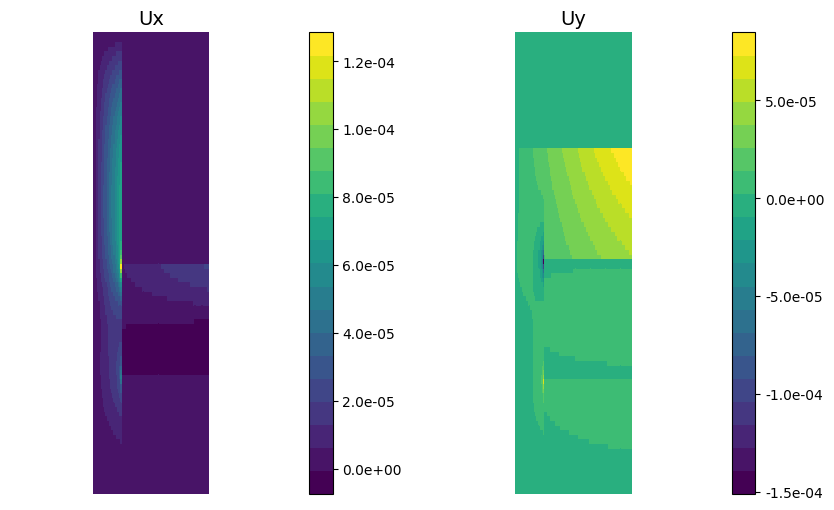

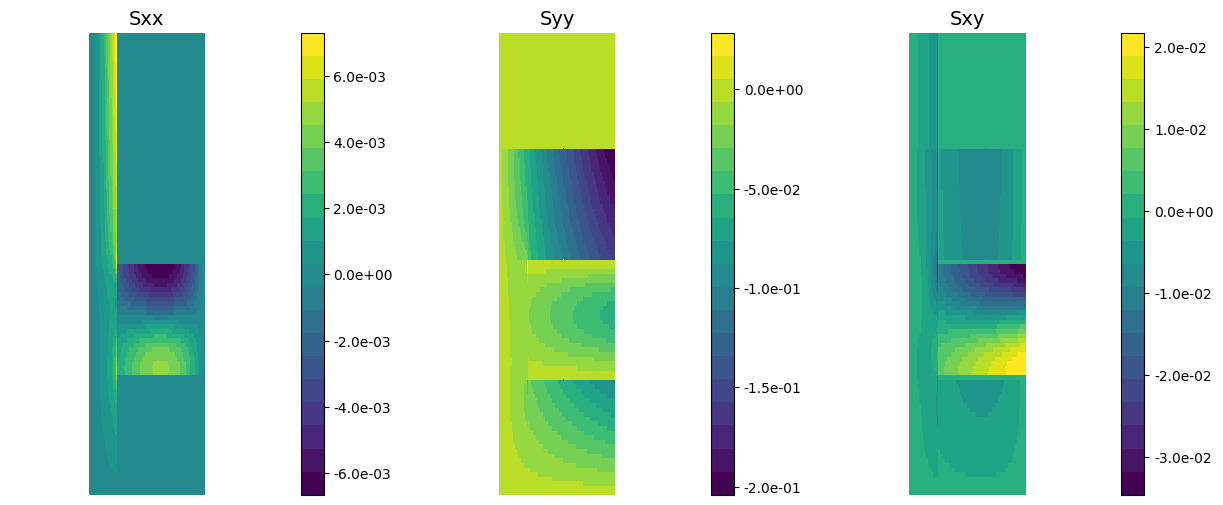

In [5]:
import matplotlib.colors as colors
import os
from scipy.interpolate import RegularGridInterpolator
import matplotlib.ticker as ticker
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
nx=100
ny=100

x_plot = np.linspace(0,x_max,nx)
y_plot = np.linspace(0,y_max,ny)
X_input = np.stack((x_plot, y_plot), axis=1)
X_plot = np.meshgrid(x_plot, y_plot, indexing='ij')

F = model.predict(X_input)
Ux = F[:, 0].reshape(nx, ny)
Uy = F[:, 1].reshape(nx, ny)
Sxx = F[:, 2].reshape(nx, ny)
Syy = F[:, 3].reshape(nx, ny)
Sxy = F[:, 4].reshape(nx, ny)

cmap = plt.get_cmap('viridis')
num_colors = 20
color_values = [cmap(i) for i in np.linspace(0, 1, num_colors)]
cmap = colors.ListedColormap(color_values)

def pcolor_plot(AX, X, Y, C, title,colormap=cmap,norm=None):

    # X, Y = compute_edges_from_nodes(X, Y)
    im = AX.pcolor(X, Y, C, cmap=colormap,shading='auto',norm=norm)

    AX.axis("equal")
    AX.axis("off")
    AX.set_title(title, fontsize=14)
    return im



fig, axs = plt.subplots(1, 2, figsize=(10, 6))
im = pcolor_plot(axs[0], X_plot[0], X_plot[1], Ux, "Ux")
fig.colorbar(im, ax=axs[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
im = pcolor_plot(axs[1], X_plot[0], X_plot[1], Uy, "Uy")
fig.colorbar(im, ax=axs[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
im = pcolor_plot(axs[0], X_plot[0], X_plot[1], Sxx, "Sxx")
fig.colorbar(im, ax=axs[0], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
im = pcolor_plot(axs[1], X_plot[0], X_plot[1], Syy, "Syy")
fig.colorbar(im, ax=axs[1], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))
im = pcolor_plot(axs[2], X_plot[0], X_plot[1], Sxy, "Sxy")
fig.colorbar(im, ax=axs[2], format=ticker.FuncFormatter(lambda x, _: f"{x:.1e}"))




In [ ]:
start_time = time.time()
losshistory, train_state = model.train(
    iterations=n_iter, display_every=log_every
)
elapsed = time.time() - start_time